# Example of usе

When I got acquainted with mlflow there were questions how it can improve the process of developing and implementing ml models with mlflow. Here we will try to consider on the example of a small ml model why it can be convenient.

## Set up

Run the mlflow server to run the following examples.

In this setup there is a trick that allows to access the `mlruns` folder where all runs for the current mlflow are stored. We add the selected folder as a volume to `mlruns` so that everything that the mlflow container creates will be stored in the selected folder `example_of_using/mlruns`.

We'll also add a folder to `.gitignore` to prevent service files from getting onto `github`.

In [1]:
%%bash
# creating folder that'll contains
# mlruns if needed
mkdir example_of_use_files &> /dev/null
mkdir example_of_use_files/mlruns &> /dev/null


docker run -p 5000:5000 -dt --name my_server --rm \
    -v $(pwd)/example_of_use_files/mlruns:/mlruns # volume for mlruns\
    ghcr.io/mlflow/mlflow \
    bash -c "mlflow server --host 0.0.0.0 --port 5000"

a429841b6a2f006e7fcd5b40a9b4dac4146a27658f6291d04501c83e9587f6e7


Don't forget to drop the mlflow server when you are finished playing with the following examples.

In [7]:
!docker stop my_server

my_server


In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix,
    roc_curve
)
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri(uri="http://localhost:5000")

## Performing a run

The following code shows the common procedure of fitting a model and the way it is logged by MLflow. It includes:

- Model - it stores object of model;
- Metrics - it stores number describing quality of model;
- Plots - sometimes it's useful to save some visualisation corresponding to the model.

All saved elements can be viewed in the MLflow GUI.

**Note** re-running the next cell in the phase of the model logging in some environments causes `UserWarning`. There is a related [issue in mlflow](https://github.com/mlflow/mlflow/issues/8605) repository associated with this problem.

2024/04/14 19:47:21 INFO mlflow.tracking.fluent: Experiment with name 'scikit_learn_experiment' does not exist. Creating a new experiment.
/home/fedor/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


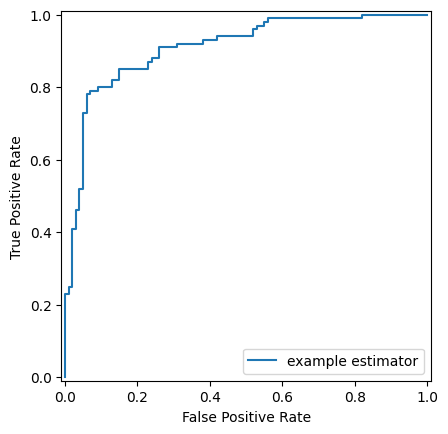

In [5]:
X,y = make_classification(
    random_state=10,
    n_samples=1000
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, 
    stratify=y, random_state=2020
)

sk_model = LogisticRegression(
    random_state=None,
    max_iter=400, 
    solver='newton-cg'
)

mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():

    # setting name to the current run
    mlflow.set_tag("mlflow.runName", "run_name")

    # fitting and logging model logging model
    sk_model.fit(X_train, y_train)
    mlflow.sklearn.log_model(sk_model,"log_reg_model")

    # saving id of the current run
    # we'll use it later to access
    # the model
    run_uuid = mlflow.active_run().info.run_uuid
    
    # logging some models metrics
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    eval_acc = sk_model.score(X_test, y_test)
    preds = sk_model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)

    # loggin picutre
    fpr, tpr, _ = roc_curve(
        y_test, sk_model.predict_proba(X_test)[:,1],
    )
    roc_plot = RocCurveDisplay(
        fpr=fpr, tpr=tpr,
        estimator_name='example estimator'
    ).plot()
    mlflow.log_figure(plt.gcf(), "sklearn_roc_plot.png")

mlflow.end_run()

## Loading model

You can access the created model using the `sklearn.load_model` function. You'll need to provide a path string describing the model you're interested in. The line should have the following syntax: `runs:/<run id>/log_reg_model`. We have saved the run id during the run. But you can also find it in the GUI.

In [9]:
mlflow.sklearn.load_model(
    f"runs:/{run_uuid}/log_reg_model"
)

LogisticRegression(max_iter=400, solver='newton-cg')